## What is this notebook for:

This notebook shows the pipeline for creating the labels from auxiliary information. I am testing all the auxiliary information sources here.


In [2]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import matplotlib
import fiona
import rasterio
from rasterio.plot import show, show_hist
from pyproj import CRS, Transformer
import re
import pandas as pd

In [3]:
file_path = 'D:/Masterarbeit/Data/raw/unlabeled/Sen1Floods11/flood/' 
file_path_BUILT = 'D:/Masterarbeit/Data/raw/auxiliary/GHSL/BUILT_all_in_one/'
file_path_LC = 'D:/Masterarbeit/Data/raw/auxiliary/Copernicus/Land_cover_classification/LC/'

In [19]:
os.listdir(file_path)

['Colombia_3986001_S1Weak.tif',
 'Ghana_3527966_S1Weak.tif',
 'India_1796024_S1Weak.tif',
 'India_1915393_S1Weak.tif',
 'Mekong_34098_S1Weak.tif',
 'Nigeria_2434449_S1Weak.tif',
 'Pakistan_2777402_S1Weak.tif',
 'Paraguay_9460560_S1Weak.tif',
 'Somalia_9757143_S1Weak.tif',
 'Spain_3382094_S1Weak.tif',
 'Sri-Lanka_5335407_S1Weak.tif',
 'USA_5510883_S1Weak.tif']

In reality i need the following pipeline:

1. Import the unlabeled satelite image
2. find the coordinates of the corners of the satelite image
3. identify the correct tile to download for the aux information
4. imprt the correct aux information tile
5. based on the corner coordinates of the unlabeled image, find the corresponding pixels in teh aux data 
6. slize the label into existence

# Align with Senfloods

## Step 1 & 2: load image and find coordinates of the unlabeled satellite image

1. load the unlabeled satelite image
2. get its corner coordinates

512 512
GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
| 0.00, 0.00,-94.70|
| 0.00,-0.00, 39.88|
| 0.00, 0.00, 1.00|
2
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 512, 'height': 512, 'count': 2, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(8.983152841195857e-05, 0.0, -94.70111590410725,
       0.0, -8.983152841195857e-05, 39.876574788179205)}


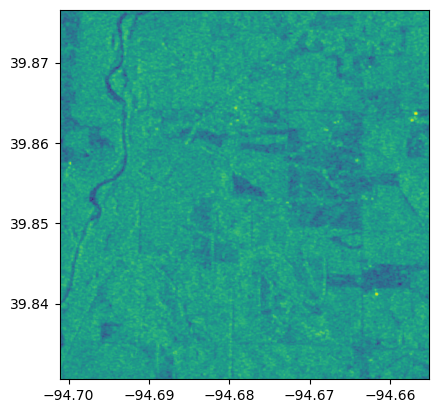

In [41]:
with rasterio.open(file_path+'USA_5510883_S1Weak.tif') as src:
        # Read the file
            array_sen = src.read(1)  # Read band 1

            print(src.width, src.height) # Dimensions
            print(src.crs) # Coordinate Reference System
            print(src.transform) # Affine transform (mapping between image and world coordinates)
            print(src.count) # number of bands

            print(src.meta)

            transform_sen = src.transform
            
            show(src)



In [6]:
import sys
sys.path.insert(0, '../src')

from alignment_helpers import *

# corner_coordinates = get_coordinates_of_corners(transform_sen, array_sen)
# corner_coordinates


## Step 3: Identify the correct tile to download of the aux information


#### BUILT & POP

In [10]:
# import shapefile
shapefile = gpd.read_file('../test_data/BUILT'+'/WGS84_tile_schema.shp')

# add the tile_ids from a downloaded csv
tile_id = pd.read_csv('../test_data/BUILT/WGS84_tile_schema.csv', header=None) # this is a file that I downloaded form GHSL website
shapefile['tile_id'] = tile_id

# # identify relevant tile_id
# tile_id = get_BUILT_polygon_encircling_unlabeled_staelite_image(shapefile, corner_coordinates)
# tile_id

#### Land Cover

In [36]:
def next_biggest_multiple_of_20(number):
    """
    Returns the next biggest multiple of 20 of the absolute value of the provided number.
    """
    if number % 20 == 0:
        return number + 20
    else:
        return number + (20 - number % 20)
    
def next_smallest_multiple_of_20(number):
    """
    Returns the next biggest multiple of 20 of the absolute value of the provided number.
    """
    if number % 20 == 0:
        return number
    else:
        return number - (number % 20)


In [37]:
def find_correct_land_cover_tile(corner_coordinates_sat):
    nbm_lon = next_smallest_multiple_of_20(corner_coordinates_sat['top_left'][0])
    nsm_lat = next_biggest_multiple_of_20(corner_coordinates_sat['top_left'][1])
    
    if corner_coordinates_sat['top_left'][0] <= 0:
        lon = 'W'
    else: lon = 'E'
    
    if corner_coordinates_sat['top_left'][1] <= 0:
        lat = 'S'
    else: lat = 'N'
    
    if nbm_lon == 0:
        lon = 'E'
        
    if nsm_lat == 0:
        lat = 'N'
        
    longt = lon+str(abs(int(nbm_lon)))
    latdt = lat+str(abs(int(nsm_lat)))

    # wenn das jetzt nur 3 stellen hat, dann inserte eine 0 an stelle 2

    if len(longt) == 3:
        longt = longt[:1] + '0' + longt[1:]
        
    elif len(longt) == 2:
        longt = longt[:1] + '00' + longt[1:]
        
    if len(latdt) == 2:
        latdt = latdt[:1] + '0' + latdt[1:]
        
    tile_id_lc = longt+latdt
    
        
    return tile_id_lc
    
        

In [38]:
tile_id_lc = find_correct_land_cover_tile(corner_coordinates)
tile_id_lc

'E060N40'

## Step 4: import the auxiliary information & analyse the CRS


#### BUILT

12000 12000
GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
| 0.00, 0.00, 69.99|
| 0.00,-0.00, 39.10|
| 0.00, 0.00, 1.00|
1
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 12000, 'height': 12000, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.0008333333300326821, 0.0, 69.9920830785043,
       0.0, -0.0008333333299795073, 39.09958337887517)}
(12000, 12000)


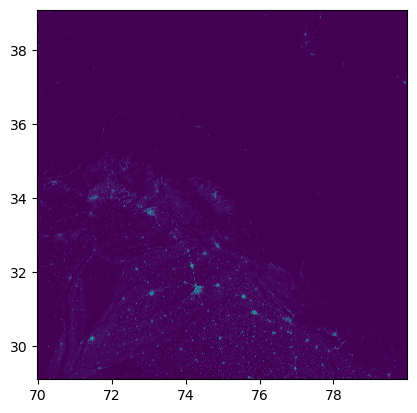

In [53]:
with rasterio.open(file_path_BUILT + 'GHS_BUILT_S_E2020_GLOBE_R2023A_4326_3ss_V1_0_'+tile_id+'.tif') as src:
    array_built = src.read(1)
    print(src.width, src.height) # Dimensions
    print(src.crs) # Coordinate Reference System
    print(src.transform) # Affine transform (mapping between image and world coordinates)
    print(src.count) # number of bands

    print(src.meta)
    print(src.shape)

    show(src) # plots the image
    # try: 
    #     show_hist(src, bins=50) # plots a histogram of the different classes available 
    # except Exception as e:
    #     print(f'an error occured: {e}')

    transform_built = src.transform


#### POP

In [18]:
tile_id

'R9_C12'

In [78]:
with rasterio.open('../test_data/POP/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0_'+tile_id+'.tif') as src:
    array_pop = src.read(1)
    print(src.width, src.height) # Dimensions
    print(src.crs) # Coordinate Reference System
    print(src.transform) # Affine transform (mapping between image and world coordinates)
    print(src.count) # number of bands

    print(src.meta)
    print(src.shape)

    # show(src) # plots the image
    # try: 
    #     show_hist(src, bins=50) # plots a histogram of the different classes available 
    # except Exception as e:
    #     print(f'an error occured: {e}')

    transform_pop = src.transform

12000 12000
GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
| 0.00, 0.00,-70.01|
| 0.00,-0.00,-10.90|
| 0.00, 0.00, 1.00|
1
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 12000, 'height': 12000, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.0008333333300326821, 0.0, -70.00791636698628,
       0.0, -0.0008333333299795073, -10.900416419895265)}
(12000, 12000)


#### Land cover

20160 20160
GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
| 0.00, 0.00, 60.00|
| 0.00,-0.00, 40.00|
| 0.00, 0.00, 1.00|
1
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 20160, 'height': 20160, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.0009920634920634888, 0.0, 60.0,
       0.0, -0.0009920634920634888, 40.0)}
(20160, 20160)


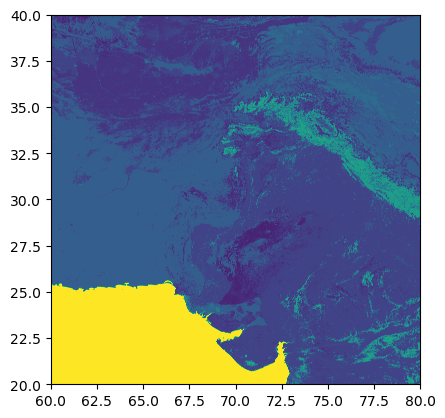

Top left longtitude: 60.0
Top left latitude: 40.0
GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
[[ 20  20  30 ...  60  60  60]
 [ 60  20  30 ...  60  60  60]
 [ 60  30  30 ...  60  60  60]
 ...
 [200 200 200 ...  40  40  40]
 [200 200 200 ...  40  40  40]
 [200 200 200 ...  40  40  40]]


In [39]:
with rasterio.open(file_path_LC+ tile_id_lc + '_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif') as src:
        # Read the file
            array_lc = src.read(1)  # Read band 1

            print(src.width, src.height) # Dimensions
            print(src.crs) # Coordinate Reference System
            print(src.transform) # Affine transform (mapping between image and world coordinates)
            print(src.count) # number of bands

            print(src.meta)
            print(src.shape)

            show(src) # plots the image
            # try: 
            #     show_hist(src, bins=50) # plots a histogram of the different classes available 
            # except Exception as e:
            #     print(f'an error occured: {e}')

            transform_lc = src.transform

            # Get coordinates of the top left corner
            # (row, col) -> (x, y)
            top_left_x, top_left_y = transform_lc * (0, 0)

            print("Top left longtitude:", top_left_x)
            print("Top left latitude:", top_left_y)
            
            
            # try getting the UTM zone:
            crs_str = str(src.crs)
            print(crs_str)
            

# Do something with the array, like print the values
print(array_lc)

In [ ]:
array_lc[]

## Step 5: Get the corresponding pixel value within the auxiliary data source

#### BUILT

In [54]:
corner_pixels_built = get_corner_pixels(corner_coordinates, transform_built)
corner_pixels_built

{'top_left': (1723, 7954),
 'top_right': (1779, 7954),
 'bottom_left': (1723, 8009),
 'bottom_right': (1779, 8009)}

#### POP

These should be the same as for the BUILT data source, as the tiles are the same

In [79]:
corner_pixels_pop = get_corner_pixels(corner_coordinates, transform_pop)
corner_pixels_pop

{'top_left': (5691, 3974),
 'top_right': (5746, 3974),
 'bottom_left': (5691, 4029),
 'bottom_right': (5746, 4029)}

#### Land cover

In [42]:
corner_pixels_lc = get_corner_pixels(corner_coordinates, transform_lc) 
corner_pixels_lc

{'top_left': (11520, 7589),
 'top_right': (11566, 7589),
 'bottom_left': (11520, 7635),
 'bottom_right': (11566, 7635)}

## Step 6: Create and plot the label

#### BUILT

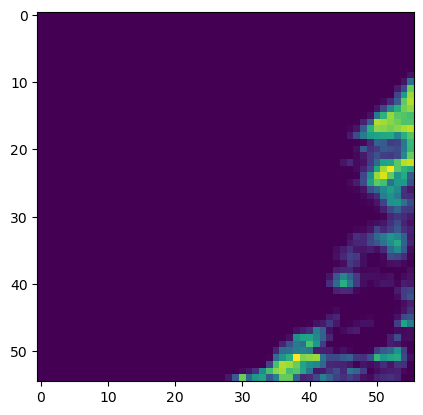

In [55]:
label_built = test_get_label_from_pixel(corner_pixels_built,array_built)

plt.imshow(label_built)

In [23]:
print(f'label shape: {label_built.shape}')
print(f"unique values in label: {list(np.unique(label_built))}")

label shape: (55, 55)
unique values in label: [0, 1]


#### POP

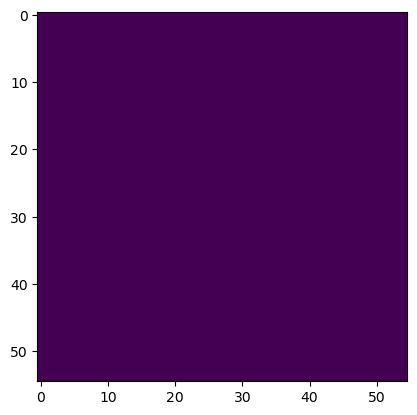

In [80]:
label_pop = get_label_from_pixel(corner_pixels_pop,array_pop)

plt.imshow(label_pop)

In [81]:
print(f'label shape: {label_pop.shape}')
print(f"unique values in label: {list(np.unique(label_pop))}")

label shape: (55, 55)
unique values in label: [0.0]


In [82]:
# save the label

import numpy as np

file_name_label = '../test_data/pop_label_senfloods.csv'

np.savetxt(file_name_label, label_pop, delimiter=',', fmt='%d')


#### Land cover

In [17]:
def test_get_label_from_pixel(corner_pixels, array_aux):
    """
    slice the aux array according to the pixel values which enircle the entire area of interest, i.e. the unlabeled image --> create the new weak label

    Args:
        corner_pixels (dict): carries the pixel coorinates in teh aux info corresponding to the geocoordinates in teh unlabeled satelite image 
        array_aux (array): array belonging to the auxiliary information (has to be only 1 layer/band (cant be RGB))

    Returns:
        array: array sliced at the pixel coordinates
    """
    return array_aux[corner_pixels['top_left'][1]: corner_pixels['bottom_left'][1], corner_pixels['top_left'][0]:corner_pixels['top_right'][0]]

In [47]:
corner_pixels_lc

{'top_left': (11520, 7589),
 'top_right': (11566, 7589),
 'bottom_left': (11520, 7635),
 'bottom_right': (11566, 7635)}

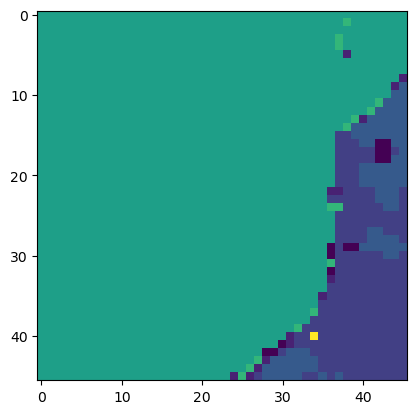

In [46]:
test_label = array_lc[7589:7635, 11520:11566]
plt.imshow(test_label)

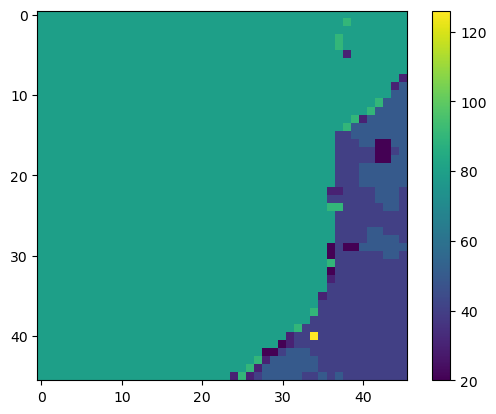

In [66]:
label_lc = test_get_label_from_pixel(corner_pixels_lc,array_lc)

plt.imshow(label_lc)
plt.colorbar()

In [25]:
print(f'label shape: {label_lc.shape}')
print(f"unique values in label: {list(np.unique(label_lc))}")

label shape: (46, 46)
unique values in label: [20, 30, 112, 116, 122, 126]


In [19]:
file_name_label = '../test_data/lc_label_senfloods.csv'

np.savetxt(file_name_label, label_lc, delimiter=',', fmt='%d')

## Final step: test if the coordinates of the label actually match those of the satelite image

In [26]:
print('coordinates of top left corner of satellite image')
print(corner_coordinates['top_left'])
print('')
print('coordinates of top left corner of BUILT label')
print(transform_built * corner_pixels_built['top_left'])
print('')
print('coordinates of top left corner of LAND COVER label')
print(transform_lc * corner_pixels_lc['top_left'])
print('')
print('coordinates of bottom right corner of satellite image')
print(corner_coordinates['bottom_right'])
print('')
print('coordinates of bottom right corner of BUILT label')
print(transform_built * corner_pixels_built['bottom_right'])
print('')
print('coordinates of bottom right corner of LAND COVER label')
print(transform_lc * corner_pixels_lc['bottom_right'])


coordinates of top left corner of satellite image
(-68.43868890981621, 4.323411799410433)

coordinates of top left corner of BUILT label
(-68.43874970653474, 4.323750185500349)

coordinates of top left corner of LAND COVER label
(-68.4384920634921, 4.323412698412751)

coordinates of bottom right corner of satellite image
(-68.3927849987977, 4.277507888391923)

coordinates of bottom right corner of BUILT label
(-68.39291637338295, 4.277916852351476)

coordinates of bottom right corner of LAND COVER label
(-68.39285714285718, 4.27777777777783)


#### check how far off they are

In [52]:
import math

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


In [29]:
# do it for BUILT

for key_s, value_s in corner_coordinates.items():
    lon_s, lat_s = corner_coordinates[key_s]
    lon_l, lat_l = transform_built * corner_pixels_built[key_s]
    print(key_s)
    print(lon_s, lat_s)
    print(lon_l, lat_l)
    hav_distance = haversine(lon_s, lat_s, lon_l, lat_l)
    print(hav_distance)


top_left
-65.26512067407877 -14.212066446998126
-65.26541638577028 -14.212083073233828
0.03192882074083523
top_right
-65.21921676306026 -14.212066446998126
-65.21958305261849 -14.212083073233828
0.03952621659979502
bottom_left
-65.26512067407877 -14.257970358016637
-65.26541638577028 -14.2579164063827
0.03242851936828822
bottom_right
-65.21921676306026 -14.257970358016637
-65.21958305261849 -14.2579164063827
0.03992819318338857


In [40]:
# do it for lc

for key_s, value_s in corner_coordinates.items():
    lon_s, lat_s = corner_coordinates[key_s]
    lon_l, lat_l = transform_lc * corner_pixels_lc[key_s]
    print(key_s)
    print(lon_s, lat_s)
    print(lon_l, lat_l)
    hav_distance = haversine(lon_s, lat_s, lon_l, lat_l)
    print(hav_distance)


top_left
-65.26512067407877 -14.212066446998126
-65.264880952381 -14.212301587301539
0.036760570675172737
top_right
-65.21921676306026 -14.212066446998126
-65.21924603174608 -14.212301587301539
0.0263360627933734
bottom_left
-65.26512067407877 -14.257970358016637
-65.264880952381 -14.25793650793646
0.02610750208894136
bottom_right
-65.21921676306026 -14.257970358016637
-65.21924603174608 -14.25793650793646
0.004910891072057182


# Align with EuroSAT

## Step 1& 2: load image and find coordinates of the unlabeled eurosat satellite image

1. load the unlabeled satelite image
2. get its corner coordinates in UTM system
3. get the images UTM zone
4. transform the UTM coordinates into WGS84 coordinates

64 64
PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
| 10.00, 0.00, 323455.65|
| 0.00,-9.98, 5507072.62|
| 0.00, 0.00, 1.00|
13
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 64, 'height': 64, 'count': 13, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETE

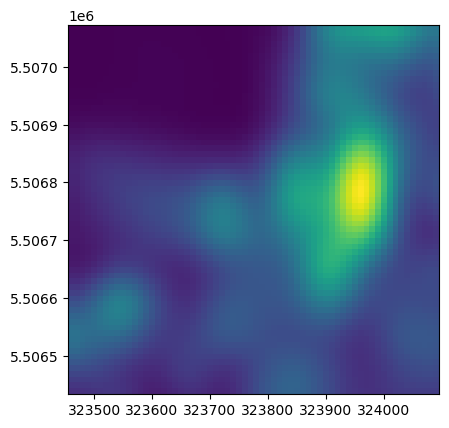

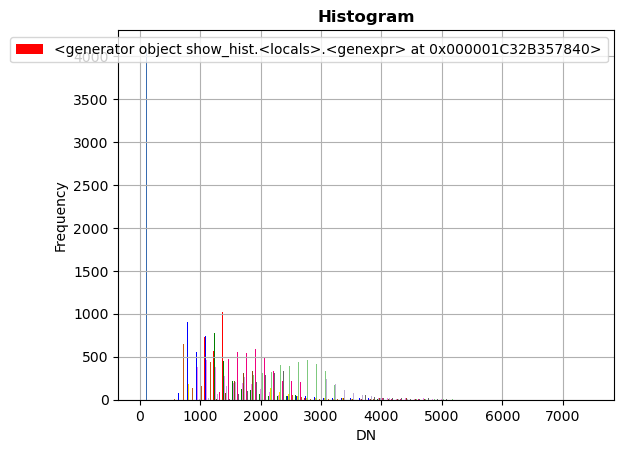

Top left longtitude: 323455.648169
Top left latitude: 5507072.615229128
PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
[[1094 1094 1092 ... 1805 1771 1762]
 [1094 1094 1092 ... 1805 1771 1762]
 [1093 1093 1091 ... 1761 1733 1730]
 ...
 [1402 1402 1403 ... 1446 1447 1445]
 [1361 1361 1366 ... 1424 1424 1423]
 [1325 1325 1333 ... 1402 1401 1401]]


In [4]:
# open the tif file, an example of the senfloods11 dataset (from the train split gedownloaded, den manüber colab öffnen kann)

with rasterio.open('../test_data/eurosat/Industrial_1.tif') as src:
        # Read the file
            array_euro = src.read(1)  # Read band 1

            print(src.width, src.height) # Dimensions
            print(src.crs) # Coordinate Reference System
            print(src.transform) # Affine transform (mapping between image and world coordinates)
            print(src.count) # number of bands

            print(src.meta)
            print(src.shape)

            show(src) # plots the image
            try: 
                show_hist(src, bins=50) # plots a histogram of the different classes available 
            except Exception as e:
                print(f'an error occured: {e}')

            transform_euro = src.transform

            # Get coordinates of the top left corner
            # (row, col) -> (x, y)
            top_left_x, top_left_y = transform_euro * (0, 0)

            print("Top left longtitude:", top_left_x)
            print("Top left latitude:", top_left_y)
            
            
            # save the crs in variable to extract the UTM zone later on 
            crs_str = str(src.crs)
            print(crs_str)
            

# Do something with the array, like print the values
print(array_euro)

In [7]:
corner_coordinates_euro = get_coordinates_of_corners(transform_euro, array_euro)

zone_nr, hemisphere = find_UTM_zone_eurosat(crs_str)

def get_coordinates_from_utm(x_coord, y_coord, zone_nr, hemisphere):
    
    
    #lat, lon = utm.to_latlon(x_coord, y_coord, zone_nr, hemisphere)
    
    # Option with pyproj commented out below
    
    # Define CRS for UTM zone and WGS84
    utm_crs = CRS(proj='utm', zone=zone_nr, ellps='WGS84', datum='WGS84')
    wgs84_crs = CRS(proj='latlong', datum='WGS84')

    # Create a transformer
    transformer = Transformer.from_crs(utm_crs, wgs84_crs)

    # Example UTM coordinates (easting, northing) in zone 
    utm_easting = x_coord
    utm_northing = y_coord

    # Convert UTM to WGS84
    lon, lat = transformer.transform(utm_easting, utm_northing)
    
    return (lon, lat)
    
def get_coordinates_of_corners_from_UTM(zone_nr, hemisphere, corner_coordinates_euro):

    wgs_coordinates_euro = {}

    for key, value in corner_coordinates_euro.items():
        lon, lat = get_coordinates_from_utm(value[0], value[1], zone_nr, hemisphere)
        wgs_coordinates_euro [key] = (lon,lat)
        
    return wgs_coordinates_euro

wgs_coordinates_euro = get_coordinates_of_corners_from_UTM(zone_nr, hemisphere, corner_coordinates_euro)
corner_coordinates_euro, wgs_coordinates_euro, zone_nr, hemisphere

({'top_left': (323455.648169, 5507072.615229128),
  'top_right': (324085.8392542307, 5507072.615229128),
  'bottom_left': (323455.648169, 5506444.084892282),
  'bottom_right': (324085.8392542307, 5506444.084892282)},
 {'top_left': (6.552172186446628, 49.69028439340107),
  'top_right': (6.56090156205137, 49.690468672831614),
  'bottom_left': (6.552455954312236, 49.68463621545983),
  'bottom_right': (6.561184320402253, 49.68482045831067)},
 '32',
 'N')

In [47]:
import utm

utm.to_latlon(323455.648169, 5507072.615229128, 32, 'N')

(49.690284413736215, 6.552172185304854)

## Step 3: Identify the correct tile of auxiliary information to download

#### BUILT

In [11]:
# # import shapefile
# shapefile = gpd.read_file('../test_data/BUILT'+'/WGS84_tile_schema.shp')

# # add the tile_ids from a downloaded csv
# tile_id = pd.read_csv('../test_data/BUILT/WGS84_tile_schema.csv', header=None) # this is a file that I downloaded form GHSL website
# shapefile['tile_id'] = tile_id

# identify relevant tile_id
tile_id = get_BUILT_polygon_encircling_unlabeled_staelite_image(shapefile, wgs_coordinates_euro)
tile_id

R4_C19 is the only tile to download


'R4_C19'

#### Land Cover

In [12]:
tile_id_lc = find_correct_land_cover_tile(wgs_coordinates_euro)
tile_id_lc

'E000N60'

## Step 4: import the auxiliary information & analyse the CRS

#### BUILT

12000 12000
GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
| 0.00, 0.00,-0.01|
| 0.00,-0.00, 59.10|
| 0.00, 0.00, 1.00|
1
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 12000, 'height': 12000, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.0008333333300326821, 0.0, -0.00791664424099281,
       0.0, -0.0008333333299795073, 59.099583298383344)}
(12000, 12000)


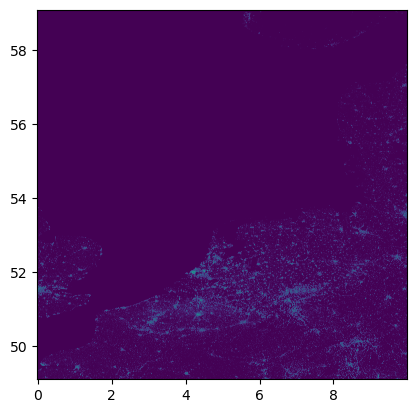

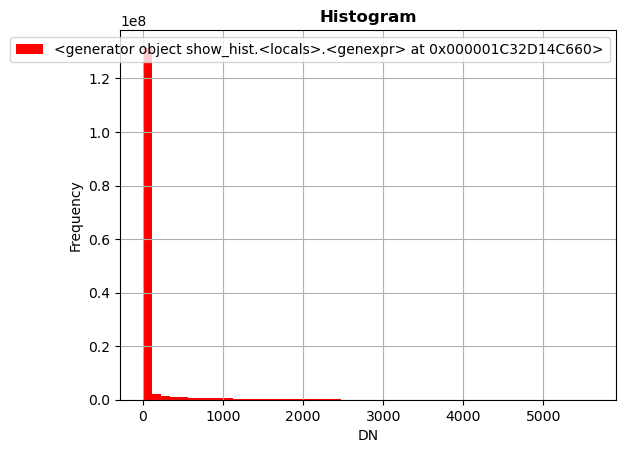

In [13]:
with rasterio.open('../test_data/BUILT/GHS_BUILT_S_E2030_GLOBE_R2023A_4326_3ss_V1_0_'+tile_id+'.tif') as src:
    array_built_2 = src.read(1)
    print(src.width, src.height) # Dimensions
    print(src.crs) # Coordinate Reference System
    print(src.transform) # Affine transform (mapping between image and world coordinates)
    print(src.count) # number of bands

    print(src.meta)
    print(src.shape)

    show(src) # plots the image
    try: 
        show_hist(src, bins=50) # plots a histogram of the different classes available 
    except Exception as e:
        print(f'an error occured: {e}')

    transform_built_2 = src.transform


#### POP

In [14]:
with rasterio.open('../test_data/POP/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0_'+tile_id+'.tif') as src:
    array_pop_2 = src.read(1)
    print(src.width, src.height) # Dimensions
    print(src.crs) # Coordinate Reference System
    print(src.transform) # Affine transform (mapping between image and world coordinates)
    print(src.count) # number of bands

    print(src.meta)
    print(src.shape)

    # show(src) # plots the image
    # try: 
    #     show_hist(src, bins=50) # plots a histogram of the different classes available 
    # except Exception as e:
    #     print(f'an error occured: {e}')

    transform_pop_2 = src.transform

12000 12000
GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
| 0.00, 0.00,-0.01|
| 0.00,-0.00, 59.10|
| 0.00, 0.00, 1.00|
1
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 12000, 'height': 12000, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.0008333333300326821, 0.0, -0.00791664424099281,
       0.0, -0.0008333333299795073, 59.099583298383344)}
(12000, 12000)


#### Land Cover

In [15]:
with rasterio.open(file_path+'/'+tile_id_lc+'_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif') as src:
        # Read the file
            array_lc_2 = src.read(1)  # Read band 1

            print(src.width, src.height) # Dimensions
            print(src.crs) # Coordinate Reference System
            print(src.transform) # Affine transform (mapping between image and world coordinates)
            print(src.count) # number of bands

            print(src.meta)
            print(src.shape)

            # show(src) # plots the image
            # try: 
            #     show_hist(src, bins=50) # plots a histogram of the different classes available 
            # except Exception as e:
            #     print(f'an error occured: {e}')

            transform_lc_2 = src.transform

            # Get coordinates of the top left corner
            # (row, col) -> (x, y)
            top_left_x, top_left_y = transform_lc_2 * (0, 0)

            print("Top left longtitude:", top_left_x)
            print("Top left latitude:", top_left_y)
            
            
            # try getting the UTM zone:
            crs_str = str(src.crs)
            print(crs_str)
            

# Do something with the array, like print the values
print(array_lc_2)

RasterioIOError: D:/Masterarbeit/Data/raw/unlabeled/Sen1Floods11/flood/E000N60_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif: No such file or directory

## Step 5: Get the corresponding pixel value within the auxiliary data source

#### BUILT

In [16]:
corner_pixels_euro_built = get_corner_pixels(wgs_coordinates_euro, transform_built_2)
corner_pixels_euro_built

{'top_left': (7872, 11291),
 'top_right': (7883, 11291),
 'bottom_left': (7872, 11298),
 'bottom_right': (7883, 11298)}

#### POP

In [88]:
corner_pixels_euro_pop = get_corner_pixels(wgs_coordinates_euro, transform_pop_2)
corner_pixels_euro_pop

{'top_left': (7872, 11291),
 'top_right': (7883, 11291),
 'bottom_left': (7872, 11298),
 'bottom_right': (7883, 11298)}

#### Land cover

In [54]:
corner_pixels_euro_lc = get_corner_pixels(wgs_coordinates_euro, transform_lc_2)
corner_pixels_euro_lc

{'top_left': (6605, 10392),
 'top_right': (6613, 10392),
 'bottom_left': (6605, 10398),
 'bottom_right': (6614, 10398)}

In [55]:
# check how misaligned the labels are with the eurosat image

# BUILT

for key_s, value_s in wgs_coordinates_euro.items():
    lon_s, lat_s = wgs_coordinates_euro[key_s]
    lon_l, lat_l = transform_built_2 * corner_pixels_euro_built[key_s]
    print(key_s)
    print(lon_s, lat_s)
    print(lon_l, lat_l)
    hav_distance = haversine(lon_s, lat_s, lon_l, lat_l)
    print(hav_distance)

top_left
6.552172186446628 49.69028439340107
6.552083329776281 49.69041666958473
0.016037255313818534
top_right
6.56090156205137 49.690468672831614
6.56124999640664 49.69041666958473
0.025722621942172525
bottom_left
6.552455954312236 49.68463621545983
6.552083329776281 49.68458333627487
0.027444813812590972
bottom_right
6.561184320402253 49.68482045831067
6.56124999640664 49.68458333627487
0.02678676894895531


In [60]:
# test a different way of getting pixel coordinates from geo coordinates

# step 1: get min lon and max lat of my auxiliary image (for which i want the pixel coordinates)


transform_built_2*(0,0), transform_built_2*(array_built_2.shape)



((-0.00791664424099281, 59.099583298383344),
 (9.992083316151191, 49.09958333862926))

In [71]:
# step 2: use the formula i found here https://www.reddit.com/r/gis/comments/tq0vbx/convert_lat_lng_to_pixel_coordinates_for_image/
import math

# the target location o want to test this method for is the top left corner of the eurosat image: (lona, lat) = (6.552172186446628, 49.69028439340107)
# my previous method comes to teh following results for the pixel coordinates of that point of the eurosat image within the built image: 'top_left': (7872, 11291)

target_lon = 6.552172186446628
target_lat = 49.69028439340107

imagepxwidth = array_built_2.shape[0]
imagepxheight = array_built_2.shape[1]

x = round(((target_lon - -0.00791664424099281) / (9.992083316151191 - -0.00791664424099281)) * imagepxwidth)
y = round(((59.099583298383344 - target_lat) / (59.099583298383344 - 49.09958333862926)) * imagepxheight)

print('top_left:')
print(x,y)

print('bottom_right:')
# what i am comparing it to : (7883, 11298)

target_lon = 6.561184320402253
target_lat = 49.68482045831067

x = round(((target_lon - -0.00791664424099281) / (9.992083316151191 - -0.00791664424099281)) * imagepxwidth)
y = round(((59.099583298383344 - target_lat) / (59.099583298383344 - 49.09958333862926)) * imagepxheight)

print(x,y)


# --> I GET THE SAME RESULTS - THIS IS BULLETPROOF

top_left:
7872 11291
bottom_right:
7883 11298


# Step 6: Create and plot the label

#### BUILT

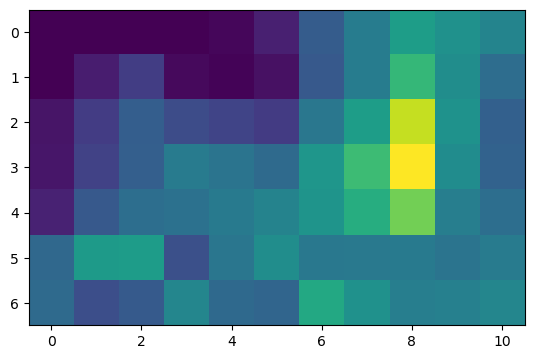

In [18]:
label_built_euro = test_get_label_from_pixel(corner_pixels_euro_built,array_built_2)

plt.imshow(label_built_euro)

In [166]:
print(f'label shape: {label_built_euro.shape}')
print(f"unique values in label: {list(np.unique(label_built_euro))}")

label shape: (11, 7)
unique values in label: [0, 1, 2, 4, 16, 18, 22, 28, 53, 74, 78, 113, 167, 193, 206, 244, 518]


In [167]:
file_name_label = '../test_data/built_label_eurosat.csv'

np.savetxt(file_name_label, label_built_euro, delimiter=',', fmt='%d')

#### POP

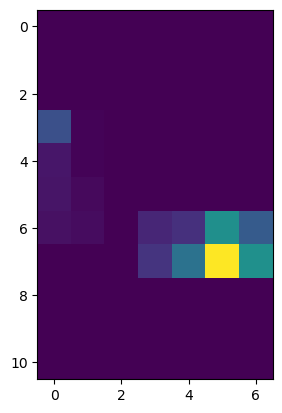

In [89]:
label_pop_euro = get_label_from_pixel(corner_pixels_euro_pop,array_pop_2)

plt.imshow(label_pop_euro)

In [90]:
print(f'label shape: {label_pop_euro.shape}')
print(f"unique values in label: {list(np.unique(label_pop_euro))}")

label shape: (11, 7)
unique values in label: [0.0, 0.000284037630384167, 0.0018178406688902113, 0.005112677346915006, 0.0060215974743995405, 0.006248827868451675, 0.008634743177228503, 0.019598595694535315, 0.02414319726328055, 0.0639084622056948, 0.07953053050571018, 0.10935447944535148, 0.13258875799106637, 0.14593853232347292, 0.2544977135128445, 0.3269273009565141, 0.35078646897131366, 0.573131120246318, 0.6714649200439453, 0.8866518333606007, 1.1750636100769043, 1.1759725304113493, 2.351490600655476]


In [91]:
file_name_label = '../test_data/pop_label_eurosat.csv'

np.savetxt(file_name_label, label_pop_euro, delimiter=',', fmt='%d')

#### Land cover

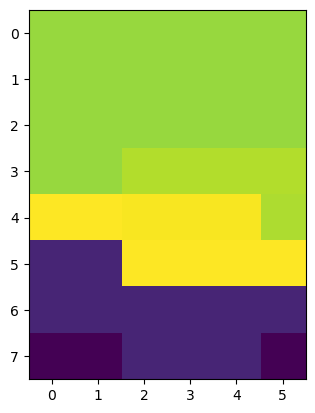

In [168]:
label_lc_euro = get_label_from_pixel(corner_pixels_euro_lc,array_lc_2)

plt.imshow(label_lc_euro)

In [169]:
print(f'label shape: {label_lc_euro.shape}')
print(f"unique values in label: {list(np.unique(label_lc_euro))}")

label shape: (8, 6)
unique values in label: [30, 40, 111, 114, 115, 125, 126]


In [170]:
file_name_label = '../test_data/lc_label_eurosat.csv'

np.savetxt(file_name_label, label_lc_euro, delimiter=',', fmt='%d')

## Final step

In [71]:
print('coordinates of top left corner of satellite image')
print(wgs_coordinates_euro['top_left'])
print('')
print('coordinates of top left corner of BUILT label')
print(transform_built_2 * corner_pixels_euro_built['top_left'])
print('')
print('coordinates of top left corner of LAND COVER label')
print(transform_lc_2 * corner_pixels_euro_lc['top_left'])
print('')
print('coordinates of bottom right corner of satellite image')
print(wgs_coordinates_euro['bottom_right'])
print('')
print('coordinates of bottom right corner of BUILT label')
print(transform_built_2 * corner_pixels_euro_built['bottom_right'])
print('')
print('coordinates of bottom right corner of LAND COVER label')
print(transform_lc_2 * corner_pixels_euro_lc['bottom_right'])

coordinates of top left corner of satellite image
(6.552172186446628, 49.69028439340107)

coordinates of top left corner of BUILT label
(6.552083329776281, 49.69041666958473)

coordinates of top left corner of LAND COVER label
(6.552579365079343, 49.690476190476225)

coordinates of bottom right corner of satellite image
(6.561184320402253, 49.68482045831067)

coordinates of bottom right corner of BUILT label
(6.56124999640664, 49.68458333627487)

coordinates of bottom right corner of LAND COVER label
(6.5615079365079145, 49.684523809523846)
